# Classification and Regression Diffusion (CARD)

## Imports

In [1]:
import os
import sys
import torch

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models import MLP, ConditionalGuidedLinearModel
from lightning_uq_box.uq_methods import CARDClassification, DeterministicClassification
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_classification,
    plot_two_moons_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

In [2]:
seed_everything(0)  # seed everything for reproducibility
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # set the GPU device
torch.set_float32_matmul_precision("medium")

Seed set to 0


In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

In [4]:
dm = TwoMoonsDataModule(batch_size=256, n_samples=8000)

X_train, y_train, X_test, y_test, test_grid_points = (
    dm.X_train,
    dm.y_train,
    dm.X_test,
    dm.y_test,
    dm.test_grid_points,
)

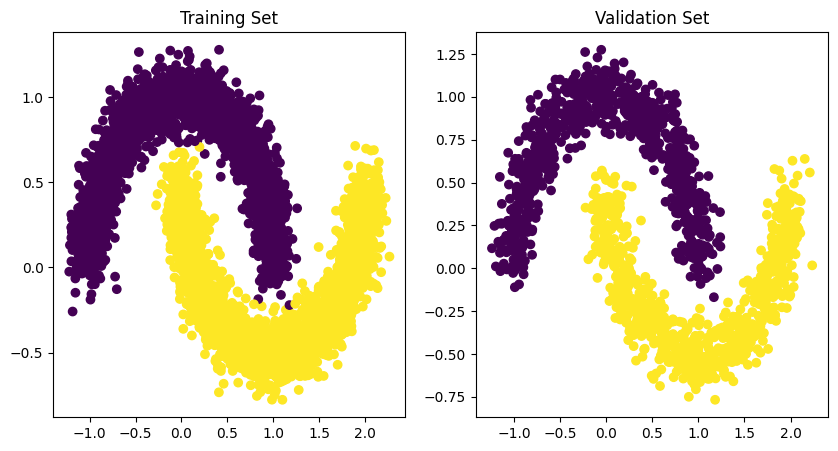

In [5]:
fig = plot_two_moons_data(X_train, y_train, X_test, y_test)

## Model

Pretrain the conditional mean estimation model before moving on to the diffusion training stage. We will use an MLP with the `DeterministicClassification` module.

In [6]:
network = MLP(n_inputs=2, n_hidden=[50, 50], n_outputs=2)

cond_mean_model = DeterministicClassification(
    model=network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    loss_fn=nn.CrossEntropyLoss(),
)

trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=False,
)
trainer.fit(cond_mean_model, dm)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.8 K 
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total par

## Diffusion Model

In [7]:
# configuration parameters

n_steps = 1000
cat_x = True  # condition on input x through concatenation
cat_y_pred = True  # condition on y_0_hat

x_dim = 2
y_dim = 2

n_hidden = [128, 128]

beta_schedule = "linear"
beta_start = 0.0001
beta_end = 0.02

In [8]:
guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
)

In [9]:
card_model = CARDClassification(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-2),
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    n_steps=n_steps,
)

In [10]:
logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=1000,  # number of epochs we want to train
    accelerator="gpu",
    devices=[0],
    logger=logger,
    log_every_n_steps=10,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)
diff_trainer.fit(card_model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpmjxxm2_7/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | MLP                          | 2.8 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 273 K 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
276 K     Trainable params
0         Non-trainable params
276 K     Total params
1.106     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1000` reached.


## Training Metrics

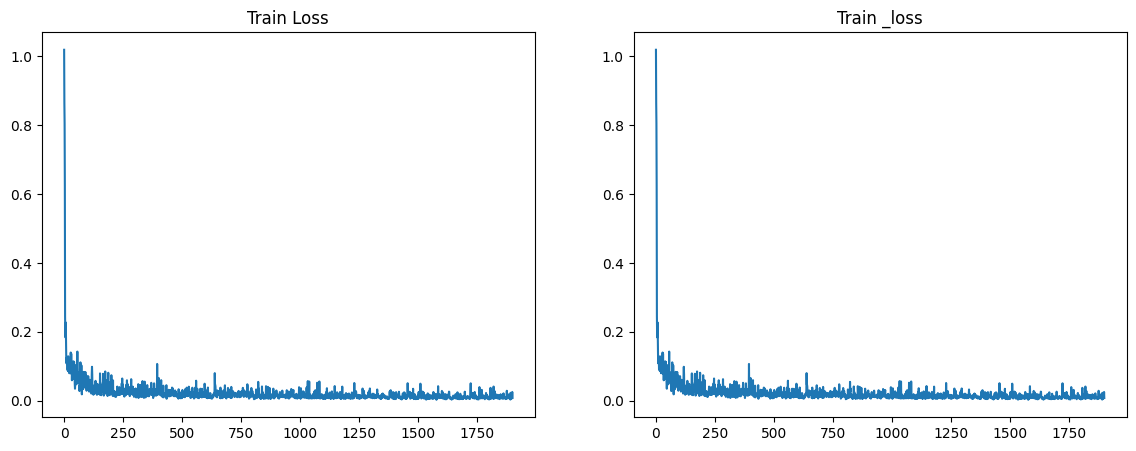

In [11]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), ["train_loss"])

## Prediction

In [12]:
card_model = card_model.to("cuda")
preds = card_model.predict_step(test_grid_points.cuda())

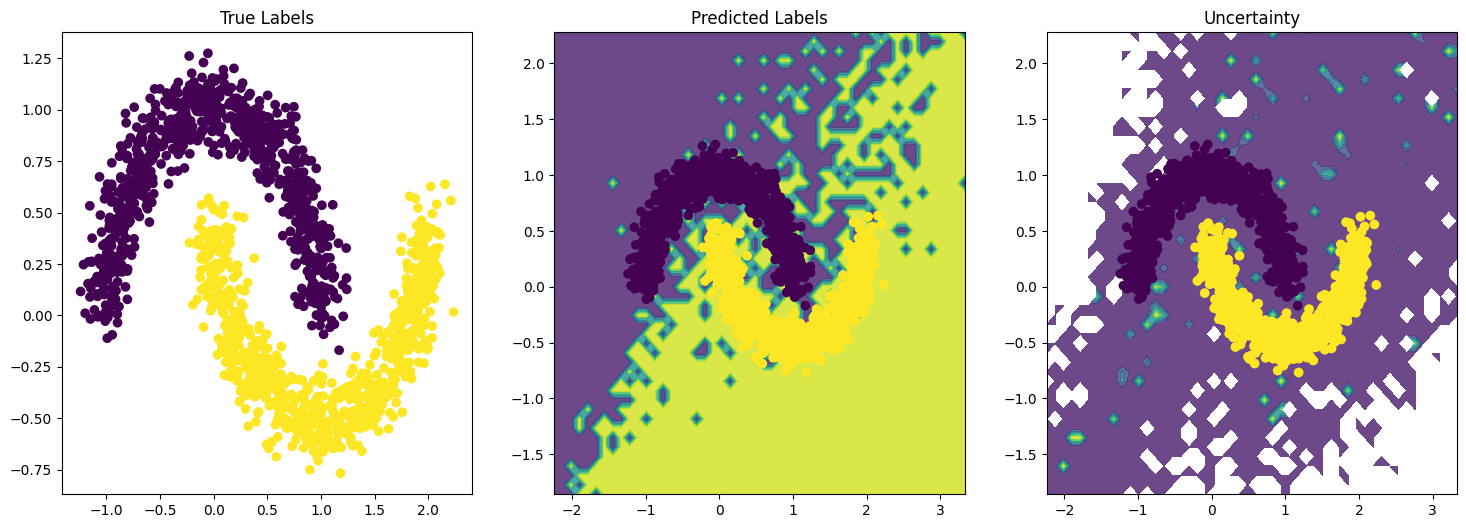

In [13]:
fig = plot_predictions_classification(
    X_test, y_test, preds["pred"].argmax(-1), test_grid_points, preds["pred_uct"]
)